# OpSim -- the updated simulation notebook

## About

This notebook is for testing of the OpSim functionality.
Data is read from prefabricated files containing the Sun and the two Satellites' positions as time series. The data is stored and read in the HDF5 format.

In [1]:
# Jupyter magic for autoreload:
%reload_ext autoreload
%autoreload 2

# Standard imports and utility ---
import  sys
import  matplotlib.pyplot as plt

sys.path.append('../')  # Add parent dir to path

# ---------------------------------------------------------
import  lusee        # Core lusee software
from    nav import * # Astro/observation wrapper classes
from    utils.timeconv import *


In [2]:
import  sim          # Main simulation handler
from    sim import Simulator

chatty = False
if chatty:
    print("---------------------------------- PATH ----------------------------------------")
    for path_part in sys.path:
        if path_part!='': print(f'''{path_part}''')

    print('--------------------------------- VERSIONS -------------------------------------')
    print(f'''simpy: {simpy.__version__}, lusee: {lusee.__version__}, sim: {sim.__version__}''')

# Define paths in one place:
orbitals    = "../data/orbitals/20260110-20270115.hdf5"
modes       = "../config/modes.yml"
devices     = "../config/devices.yml"

#comtable    = "../config/comtable-20260110-20270115.yml"
#comtable    = "./simulator_log.yml"
comtable = None

initial_time=2
until=4000
#2780

smltr = Simulator(orbitals, modes, devices, comtable, initial_time=initial_time, until=until, verbose=True)

mjd_start   = smltr.sun.mjd[initial_time]
mjd_end     = smltr.sun.mjd[until]

if chatty:
    print(f'''Initial time in ticks: {initial_time}, mjd: {mjd_start}, datetime: {mjd2dt(mjd_start)}, Sun Alt: {smltr.sun.alt[initial_time]}''')
    print(f'''Until time in ticks: {until}, mjd: {mjd_end}, datetime: {mjd2dt(mjd_end)}''')
    print(smltr.schedule)

# OPTIONAL
# smltr.info()

Shape of the data payload: (35450, 7)
Created a Battery with initial charge: 385714.2857142857, capacity: 879428.5714285714
Created a SSD with initial fill: 0.0, capacity: 32000000.0
Lander pitch, roll, yaw: [0. 0. 0.]
Adding panel EPanel with normal [1. 0. 0.], 	efficiency 1.0, and surface area 0.1565
Adding panel WPanel with normal [-1.  0.  0.], 	efficiency 1.0, and surface area 0.1565
Adding panel TPanel with normal [0. 0. 1.], 	efficiency 1.0, and surface area 0.313


In [3]:
smltr.power_info()

Mode:  science
     Device: PDU          :  0.9 W
     Device: UT           :  0.0 W
     Device: DCB          :  2.0 W
     Device: preamp       :  0.9 W
     Device: PFPS         :  7.5 W
     Device: PCDU         :  0.8 W
     Device: spectrometer : 11.5 W
   Total power: 23.6 W

Mode:  maint
     Device: PDU          :  0.9 W
     Device: UT           :  5.3 W
     Device: DCB          :  2.0 W
     Device: preamp       :  0.9 W
     Device: PFPS         :  2.3 W
     Device: PCDU         :  1.5 W
     Device: spectrometer :  0.0 W
   Total power: 12.9 W

Mode:  powersave
     Device: PDU          :  0.9 W
     Device: UT           :  0.0 W
     Device: DCB          :  2.0 W
     Device: preamp       :  0.9 W
     Device: PFPS         :  2.3 W
     Device: PCDU         :  0.8 W
     Device: spectrometer :  0.0 W
   Total power:  6.9 W



---

### Run the simulation

In [4]:
# Set verbose if needed:
smltr.verbose = False # True
smltr.simulate(create_command_table=True)
comtable = '/tmp/current-command-table.yml'
smltr.save_record(comtable)


In [5]:
## now run again with generated command table
comtable = '/tmp/current-command-table.yml'
smltr = Simulator(orbitals, modes, devices, comtable, initial_time=initial_time, until=until)
smltr.verbose = False # True
smltr.simulate()

---

### Plot the results

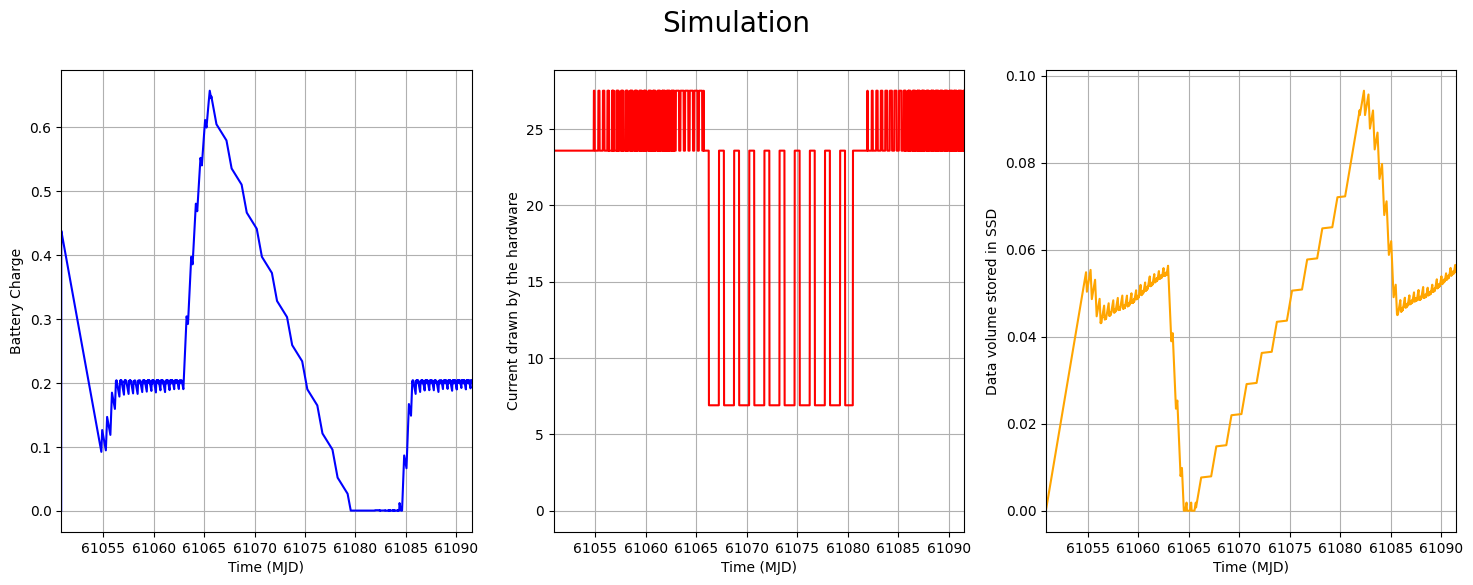

In [6]:
fig, (p1, p2, p3) = plt.subplots(1,3, figsize=(18,6))
fig.suptitle('Simulation', fontsize=20)
plt.rcParams["figure.figsize"] = [18., 6.]
# plt.rcParams["figure.autolayout"] = True


p1.set_xlabel('Time (MJD)')
p1.set_ylabel('Battery Charge')

p2.set_xlabel('Time (MJD)')
p2.set_ylabel('Current drawn by the hardware')

p3.set_xlabel('Time (MJD)')
p3.set_ylabel('Data volume stored in SSD')

mjd = smltr.sun.mjd
p1.plot(mjd, smltr.monitor.battery, color="blue",   label="Battery")
p2.plot(mjd, smltr.monitor.power, color="red",    label="Power drawn")
p3.plot(mjd, smltr.monitor.ssd,     color="orange", label="SSD")

xlo = mjd[smltr.initial_time]
xhi = mjd[smltr.until] - 1

p1.set_xlim([xlo, xhi])
p2.set_xlim([xlo, xhi])
p3.set_xlim([xlo, xhi])

p1.grid(True)
p2.grid(True)
p3.grid(True)

plt.show()





In [7]:
# Keep a cell for debugging:
# for c in smltr.monitor.current:
#    print(c)

---

### Optional -- some graphs.



35450


(61110.0, 61114.0)

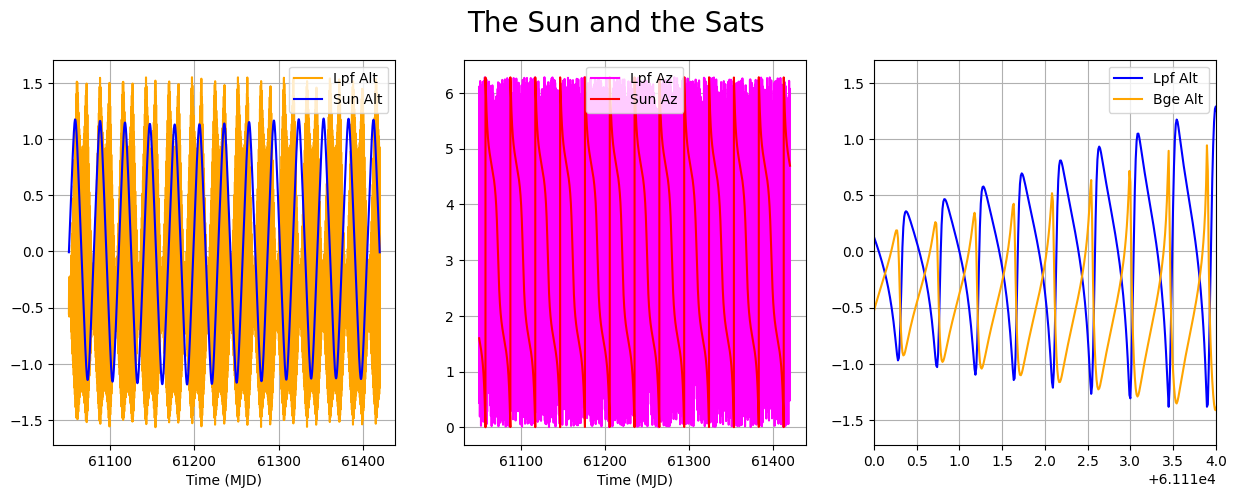

In [8]:
# OPTIONAL PLOTS

plt.rcParams["figure.figsize"] = [15., 5.]

# Get a handle on the sun and the satellite, in case needed for diagnostics
mySun = smltr.sun
myLpf = smltr.lpf
myBge = smltr.bge

print(mySun.N)

fig, (p1, p2, p3) = plt.subplots(1,3)

fig.suptitle('The Sun and the Sats', fontsize=20)
plt.rcParams["figure.figsize"] = [20., 8.]
plt.rcParams["figure.autolayout"] = True


p1.set_xlabel('Time (MJD)')
p2.set_xlabel('Time (MJD)')

p1.plot(myLpf.mjd, myLpf.alt,  color="orange", label="Lpf Alt")
p1.plot(mySun.mjd, mySun.alt,  color="blue",   label="Sun Alt")

p2.plot(myLpf.mjd, myLpf.az, color="magenta",label="Lpf Az")
p2.plot(mySun.mjd, mySun.az, color="red",    label="Sun Az")


p3.plot(myLpf.mjd, myLpf.alt,  color="blue", label="Lpf Alt")
p3.plot(myBge.mjd, myBge.alt,  color="orange", label="Bge Alt")

p1.grid(True)
_ = p1.legend()

p2.grid(True)
_ = p2.legend()

p3.grid(True)
_ = p3.legend()
p3.set_xlim(61110,61114)

Sunrise: 61331.302083333336


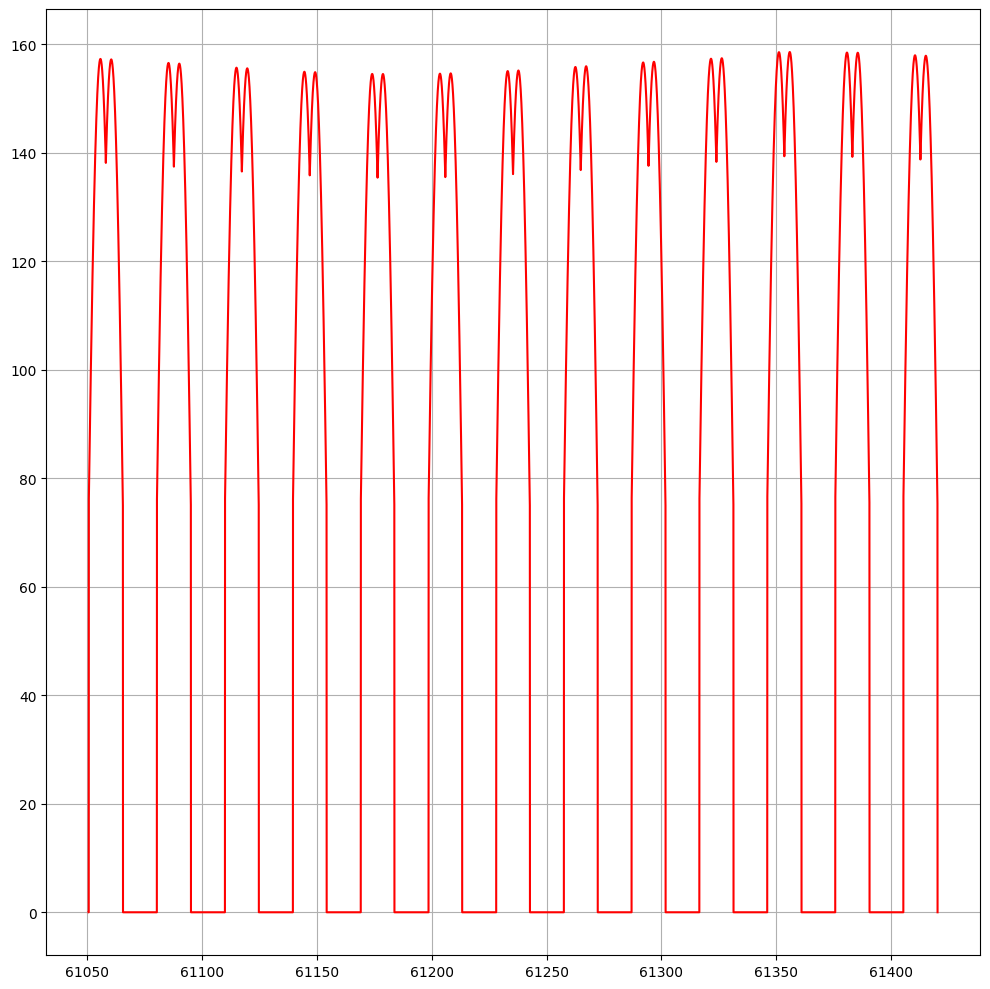

In [9]:
# OPTIONAL

print(f'''Sunrise: {mySun.sunrise}''')

plt.rcParams["figure.figsize"] = [10., 10.]
# plt.rcParams["figure.autolayout"] = True

ax=plt.subplot()

ax.plot(mySun.mjd, smltr.controller.power,  color="red",    label="Panel power*100")
ax.grid(True)
